# RTLS Workshop Analysis: Station Detection and Time Prediction

This notebook performs comprehensive analysis on Real-Time Location System (RTLS) data for a **single workshop**:
- **Phase 1**: Station Boundary Detection using clustering
- **Phase 2**: Temporal Analysis (dwell time, travel time between stations)
- **Phase 3**: Predictive Modeling (next station arrival, total completion time)

## Data Structure
- `name`: Group identifier (e.g., "Group 1")
- `x`, `y`, `z`: 3D coordinates from RTLS
- `time`: Timestamp of measurement
- `workshop`: Workshop session identifier

---
**Note:** Each workshop is analyzed independently. Set the workshop number in the cell below.

## Setup and Data Loading

In [1]:
# ============================================
# WORKSHOP SELECTION
# ============================================
# Change this to analyze a different workshop
# Valid options: "Workshop1", "Workshop2", "Workshop3"

WORKSHOP = "Workshop2"  # 👈 CHANGE THIS VALUE

# ============================================

print(f"🎯 Selected Workshop: {WORKSHOP}")
print(f"{'='*50}")
print(f"This analysis will run on {WORKSHOP} data only.")
print(f"{'='*50}\n")

🎯 Selected Workshop: Workshop2
This analysis will run on Workshop2 data only.



## 🎯 Workshop Selection

**IMPORTANT:** Set which workshop to analyze here!

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [3]:
# Load data for the selected workshop
data_file = f'../data/raw/{WORKSHOP}.csv'

print(f"Loading data from: {data_file}")
df = pd.read_csv(data_file)

# Convert time to datetime
df['time'] = pd.to_datetime(df['time'])

# Sort by group and time
df = df.sort_values(['name', 'time']).reset_index(drop=True)

print(f"\n{'='*60}")
print(f"📊 {WORKSHOP} Dataset Summary")
print(f"{'='*60}")
print(f"Dataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Date Range: {df['time'].min()} to {df['time'].max()}")
print(f"Groups in this workshop: {sorted(df['name'].unique())}")
print(f"Number of groups: {df['name'].nunique()}")
print(f"Total Data Points: {len(df):,}")
print(f"{'='*60}\n")

df.head(10)

Loading data from: ../data/raw/Workshop2.csv

📊 Workshop2 Dataset Summary
Dataset Shape: (17676, 5)
Columns: ['name', 'x', 'y', 'z', 'time']
Date Range: 2025-08-01 12:59:01.128524 to 2025-08-01 15:35:32.102986
Groups in this workshop: ['Group 1', 'Group 2', 'Group 3', 'Group 5', 'Group 6', 'group 4']
Number of groups: 6
Total Data Points: 17,676



,name,x,y,z,time
0,Group 1,33.72,11.58,1.34,2025-08-01 12:59:31.008282
1,Group 1,33.07,12.17,0.86,2025-08-01 12:59:32.006217
2,Group 1,32.94,13.87,1.86,2025-08-01 12:59:34.006532
3,Group 1,33.18,14.03,1.92,2025-08-01 12:59:35.006176
4,Group 1,34.07,16.53,3.32,2025-08-01 12:59:42.013288
5,Group 1,34.26,15.98,1.71,2025-08-01 12:59:43.006495
6,Group 1,34.37,15.48,0.54,2025-08-01 12:59:44.006425
7,Group 1,34.46,15.19,-0.53,2025-08-01 12:59:45.006623
8,Group 1,34.61,16.34,-0.55,2025-08-01 12:59:55.007319
9,Group 1,34.73,15.88,-1.32,2025-08-01 12:59:56.010129


In [4]:
# Basic data exploration
print("Coordinate Statistics:")
print(df[['x', 'y', 'z']].describe())

print("\nData Points per Group:")
print(df.groupby('name').size().to_frame('count'))

Coordinate Statistics:
                  x             y             z
count  17676.000000  17676.000000  17676.000000
mean      37.526448     13.874266     -0.282998
std        3.368710      3.297314      2.867751
min       27.280000      5.410000     -6.610000
25%       34.700000     11.820000     -2.740000
50%       37.730000     14.180000     -0.540000
75%       40.640000     15.960000      1.930000
max       47.240000     21.120000      5.740000

Data Points per Group:
         count
name          
Group 1   2960
Group 2   2014
Group 3   3798
Group 5   2968
Group 6   3083
group 4   2853


---
# Phase 1: Station Boundary Detection

Use clustering algorithms to identify distinct stations/zones where groups spend time during the workshop.

## 1.1 Visualize Raw Data

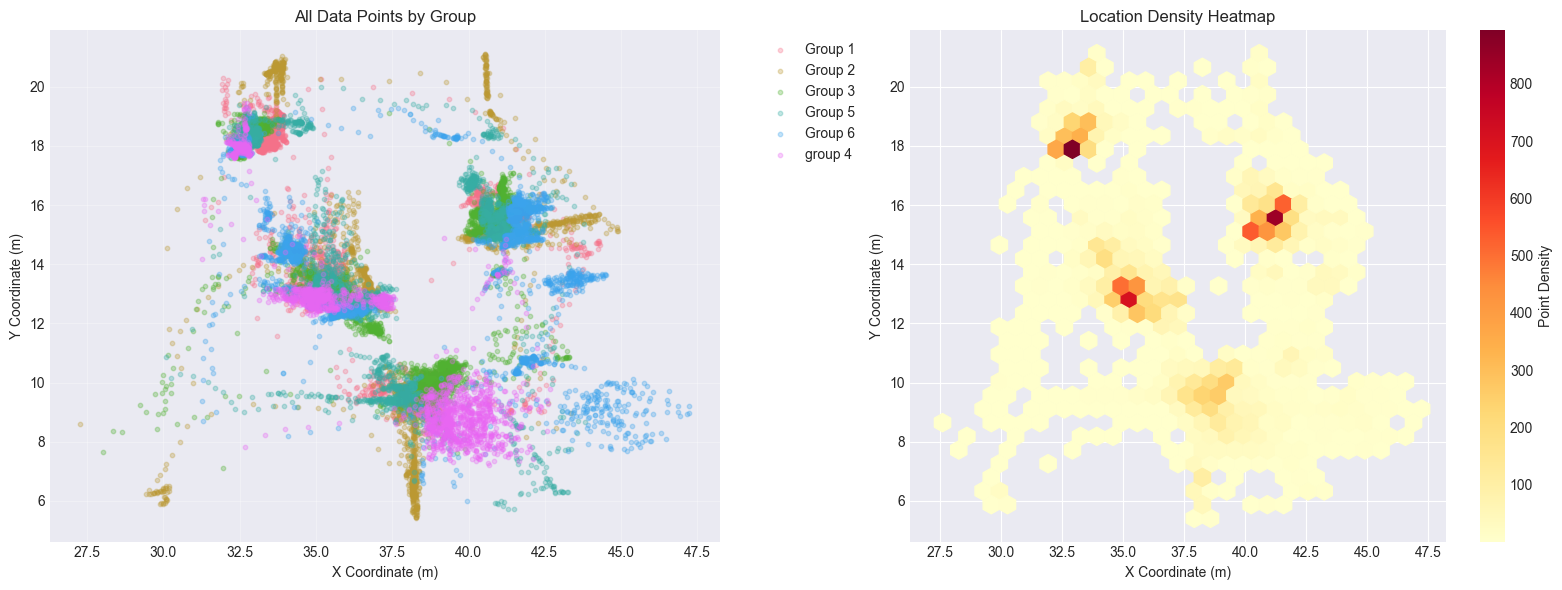

High-density areas likely represent stations where groups spent significant time.


In [5]:
# Visualize all data points in 2D space
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: All points colored by group
for group in df['name'].unique():
    group_data = df[df['name'] == group]
    axes[0].scatter(group_data['x'], group_data['y'], alpha=0.3, s=10, label=group)
axes[0].set_xlabel('X Coordinate (m)')
axes[0].set_ylabel('Y Coordinate (m)')
axes[0].set_title('All Data Points by Group')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)

# Plot 2: Density heatmap
axes[1].hexbin(df['x'], df['y'], gridsize=30, cmap='YlOrRd', mincnt=1)
axes[1].set_xlabel('X Coordinate (m)')
axes[1].set_ylabel('Y Coordinate (m)')
axes[1].set_title('Location Density Heatmap')
plt.colorbar(axes[1].collections[0], ax=axes[1], label='Point Density')

plt.tight_layout()
plt.show()

print("High-density areas likely represent stations where groups spent significant time.")

## 1.2 K-Means Clustering: Find Optimal Number of Stations

In [6]:
# Prepare clustering data (use X, Y coordinates)
coords = df[['x', 'y']].values

# Standardize coordinates for better clustering
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# Sample data for faster computation (if dataset is large)
sample_size = min(20000, len(df))
sample_idx = np.random.choice(len(df), sample_size, replace=False)
coords_sample = coords_scaled[sample_idx]

print(f"Using {sample_size:,} sample points for optimal k analysis")

Using 17,676 sample points for optimal k analysis


k=2: Inertia=18817.31, Silhouette=0.457
k=3: Inertia=9653.94, Silhouette=0.589
k=3: Inertia=9653.94, Silhouette=0.589
k=4: Inertia=3980.99, Silhouette=0.691
k=4: Inertia=3980.99, Silhouette=0.691
k=5: Inertia=3181.05, Silhouette=0.675
k=5: Inertia=3181.05, Silhouette=0.675
k=6: Inertia=2733.71, Silhouette=0.683
k=6: Inertia=2733.71, Silhouette=0.683
k=7: Inertia=2422.61, Silhouette=0.616
k=7: Inertia=2422.61, Silhouette=0.616
k=8: Inertia=2160.66, Silhouette=0.589
k=8: Inertia=2160.66, Silhouette=0.589
k=9: Inertia=1882.25, Silhouette=0.569
k=9: Inertia=1882.25, Silhouette=0.569
k=10: Inertia=1667.54, Silhouette=0.545
k=10: Inertia=1667.54, Silhouette=0.545
k=11: Inertia=1527.05, Silhouette=0.532
k=11: Inertia=1527.05, Silhouette=0.532
k=12: Inertia=1400.89, Silhouette=0.519
k=12: Inertia=1400.89, Silhouette=0.519
k=13: Inertia=1291.43, Silhouette=0.471
k=13: Inertia=1291.43, Silhouette=0.471
k=14: Inertia=1189.87, Silhouette=0.415
k=14: Inertia=1189.87, Silhouette=0.415
k=15: Inertia=

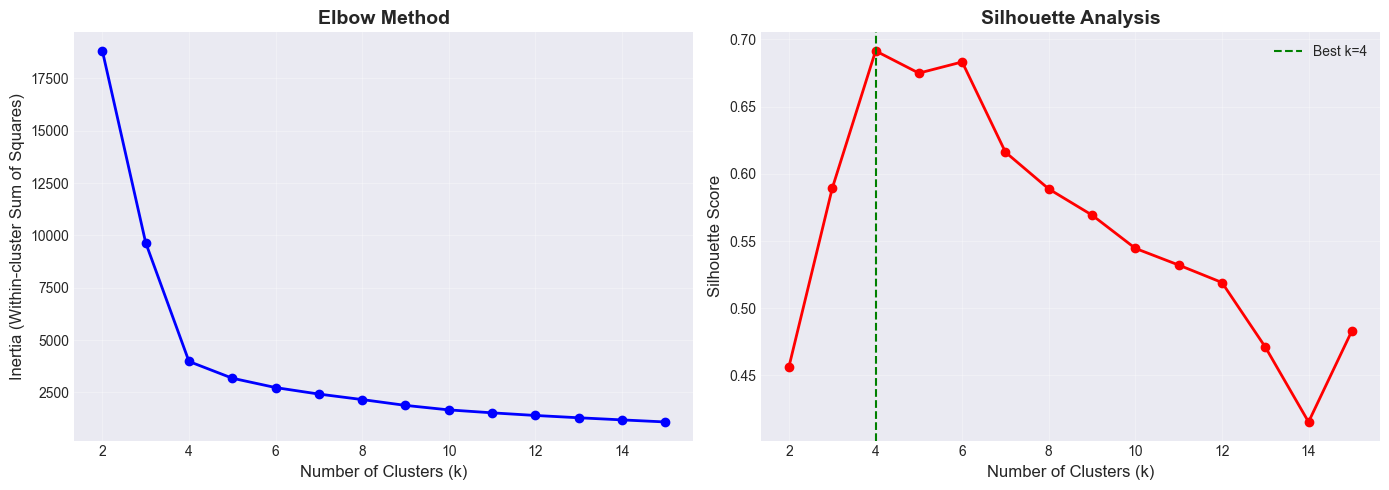


✅ Recommended number of stations (clusters): 4
   Silhouette score: 0.691


In [7]:
# Elbow method and silhouette analysis
k_range = range(2, 16)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(coords_sample)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(coords_sample, labels))
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}")

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow curve
axes[0].plot(k_range, inertias, 'bo-', linewidth=2)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette scores
axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
axes[1].axvline(x=best_k_silhouette, color='green', linestyle='--', label=f'Best k={best_k_silhouette}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n✅ Recommended number of stations (clusters): {best_k_silhouette}")
print(f"   Silhouette score: {max(silhouette_scores):.3f}")

## 1.3 Apply K-Means with Optimal k

In [8]:
# Use the optimal k (or manually set based on domain knowledge)
optimal_k = best_k_silhouette  # You can override this: optimal_k = 6

# Fit K-Means on full dataset
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['station'] = kmeans.fit_predict(coords_scaled)

# Get station centroids in original scale
centroids_scaled = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

# Create station info dataframe
station_info = pd.DataFrame({
    'station': range(optimal_k),
    'centroid_x': centroids_original[:, 0],
    'centroid_y': centroids_original[:, 1]
})

print("Station Centroids:")
print(station_info)
print(f"\nPoints per station:")
print(df['station'].value_counts().sort_index())

Station Centroids:
   station  centroid_x  centroid_y
0        0   39.310866    9.240563
1        1   33.084167   18.337630
2        2   41.230273   15.558877
3        3   35.228994   13.110322

Points per station:
station
0    4191
1    3300
2    5094
3    5091
Name: count, dtype: int64


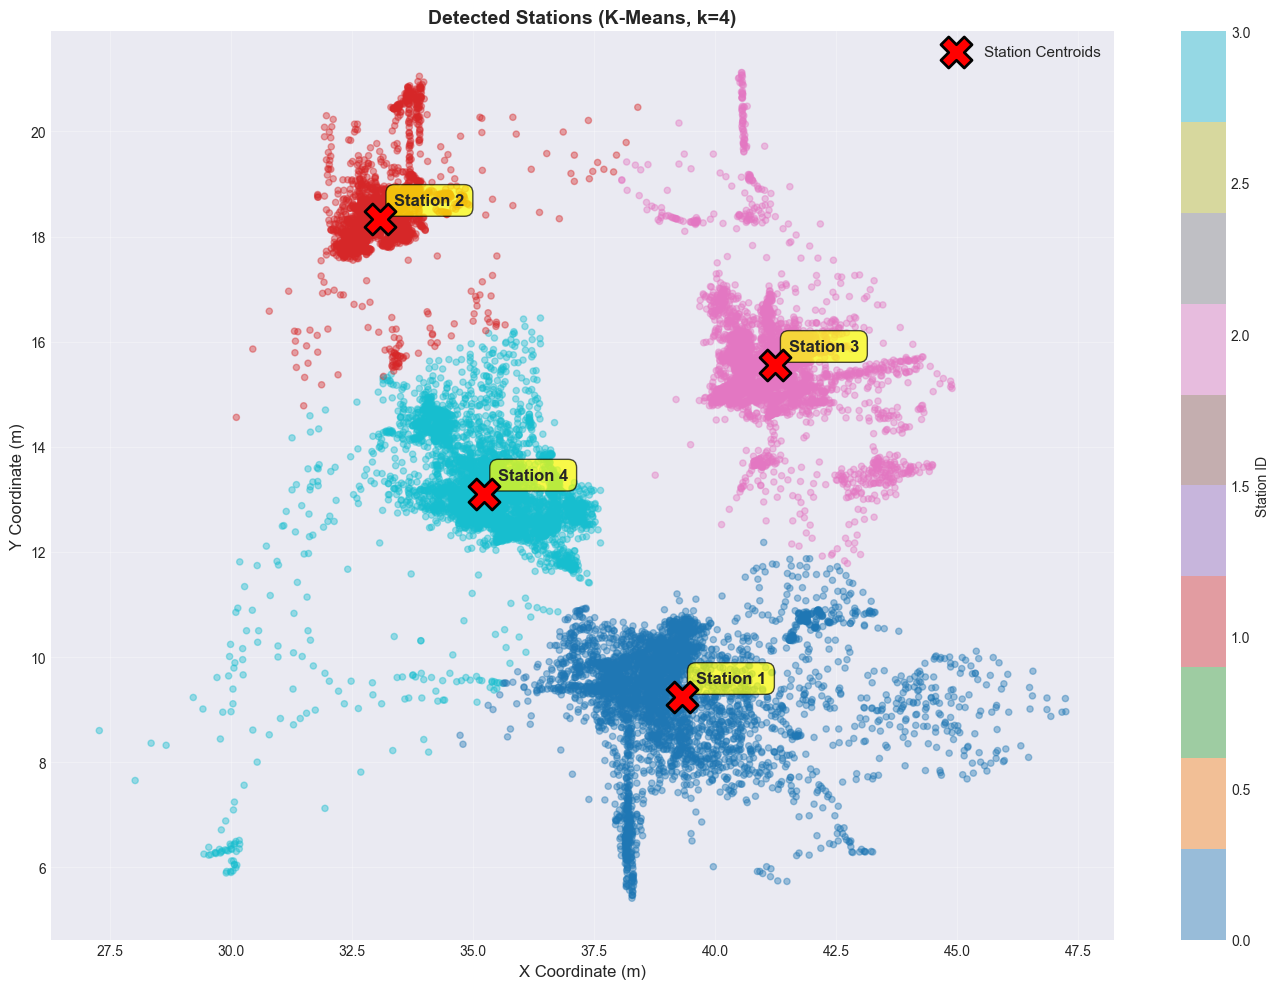

In [29]:
# Visualize stations
fig, ax = plt.subplots(figsize=(14, 10))

# Plot all points colored by station
scatter = ax.scatter(df['x'], df['y'], c=df['station'], cmap='tab10', alpha=0.4, s=20)

# Plot centroids
ax.scatter(station_info['centroid_x'], station_info['centroid_y'], 
           c='red', marker='X', s=500, edgecolors='black', linewidths=2,
           label='Station Centroids', zorder=5)

# Add station labels
for idx, row in station_info.iterrows():
    ax.annotate(f'Station {idx + 1}', 
                xy=(row['centroid_x'], row['centroid_y']),
                xytext=(10, 10), textcoords='offset points',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

ax.set_xlabel('X Coordinate (m)', fontsize=12)
ax.set_ylabel('Y Coordinate (m)', fontsize=12)
ax.set_title(f'Detected Stations (K-Means, k={optimal_k})', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Station ID')
plt.tight_layout()
plt.show()

## 1.4 Alternative: DBSCAN Clustering (Density-Based)

DBSCAN can detect stations of arbitrary shape and automatically determine the number of clusters.

In [10]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=50)  # Adjust eps and min_samples based on data
df['station_dbscan'] = dbscan.fit_predict(coords_scaled)

n_clusters_dbscan = len(set(df['station_dbscan'])) - (1 if -1 in df['station_dbscan'] else 0)
n_noise = list(df['station_dbscan']).count(-1)

print(f"DBSCAN Results:")
print(f"  Number of stations detected: {n_clusters_dbscan}")
print(f"  Noise points (not assigned to any station): {n_noise}")
print(f"\nPoints per station:")
print(df['station_dbscan'].value_counts().sort_index())

DBSCAN Results:
  Number of stations detected: 2
  Noise points (not assigned to any station): 191

Points per station:
station_dbscan
-1      191
 0    17485
Name: count, dtype: int64


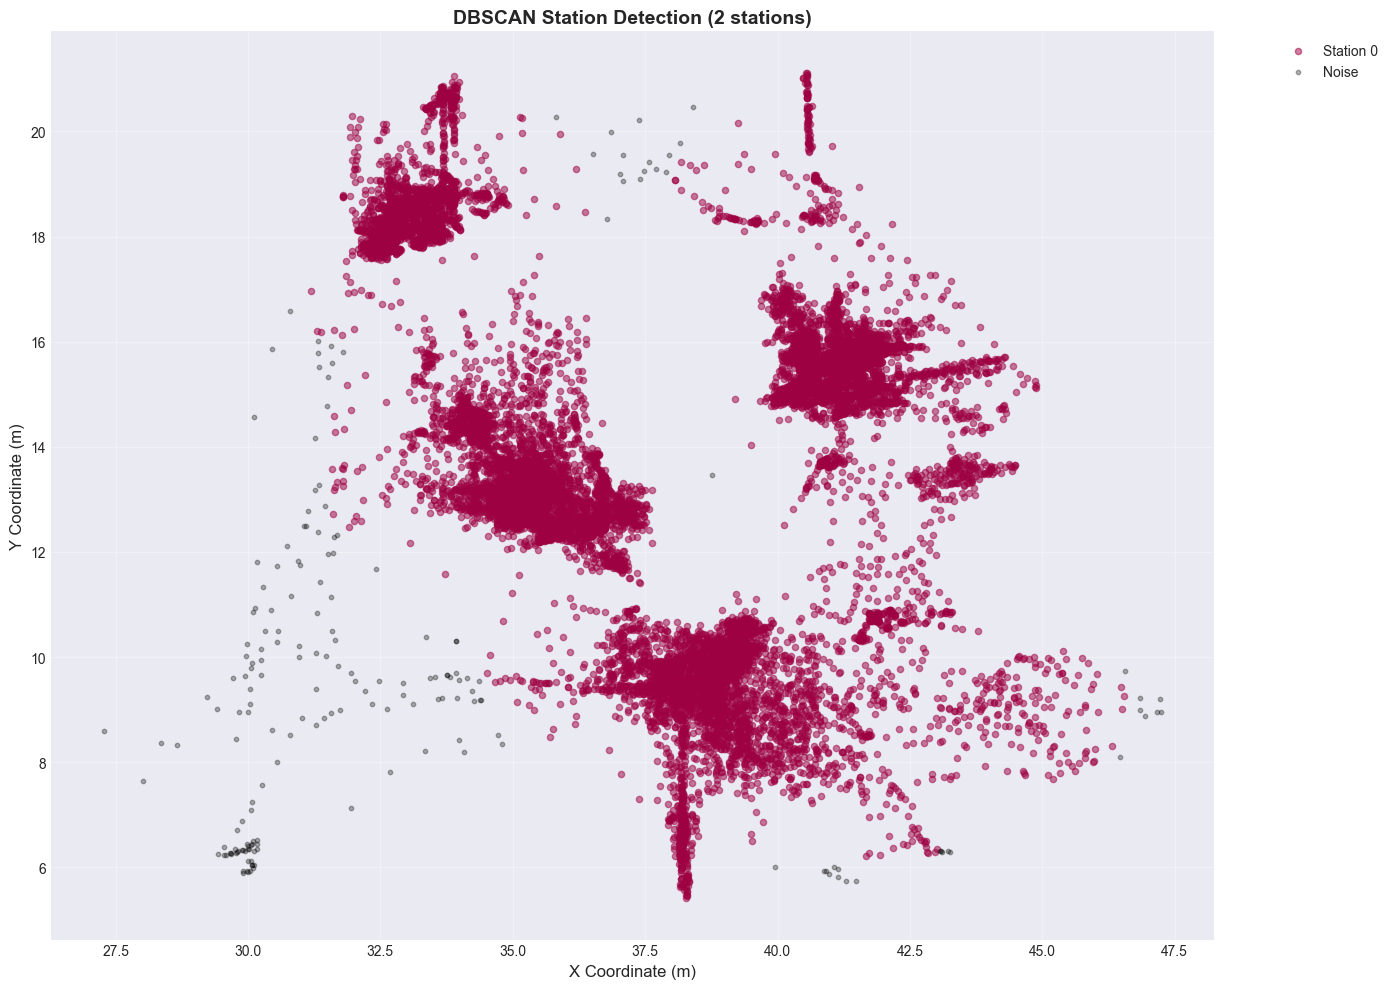


💡 DBSCAN rejected in most cases as K-Means provides more reliable results.
   We'll continue with K-Means stations for the rest of the analysis.


In [11]:
# Visualize DBSCAN results
fig, ax = plt.subplots(figsize=(14, 10))

# Plot points (noise points in black)
unique_labels = set(df['station_dbscan'])
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        color = 'black'
        marker_size = 10
        alpha = 0.3
        label_text = 'Noise'
    else:
        marker_size = 20
        alpha = 0.5
        label_text = f'Station {label}'
    
    mask = df['station_dbscan'] == label
    ax.scatter(df[mask]['x'], df[mask]['y'], 
               c=[color], s=marker_size, alpha=alpha, label=label_text)

ax.set_xlabel('X Coordinate (m)', fontsize=12)
ax.set_ylabel('Y Coordinate (m)', fontsize=12)
ax.set_title(f'DBSCAN Station Detection ({n_clusters_dbscan} stations)', 
             fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 DBSCAN rejected in most cases as K-Means provides more reliable results.")
print("   We'll continue with K-Means stations for the rest of the analysis.")

---
# Phase 2: Temporal Analysis

Analyze how groups move between stations and calculate:
1. **Dwell Time**: How long groups stay at each station
2. **Travel Time**: Time taken to move between stations

## 2.1 Identify Station Visits

In [12]:
# Identify consecutive station visits for each group
def identify_visits(group_df):
    """
    Identify distinct station visits by detecting when station changes.
    A visit is a continuous period at the same station.
    """
    visits = []
    visit_id = 0
    
    if len(group_df) == 0:
        return []
    
    current_station = group_df.iloc[0]['station']
    visit_start_idx = 0
    
    for idx in range(1, len(group_df)):
        if group_df.iloc[idx]['station'] != current_station:
            # Station changed - save previous visit
            visit_data = group_df.iloc[visit_start_idx:idx]
            visits.append({
                'visit_id': visit_id,
                'station': current_station,
                'start_time': visit_data['time'].iloc[0],
                'end_time': visit_data['time'].iloc[-1],
                'duration_seconds': (visit_data['time'].iloc[-1] - visit_data['time'].iloc[0]).total_seconds(),
                'num_points': len(visit_data)
            })
            
            # Start new visit
            visit_id += 1
            current_station = group_df.iloc[idx]['station']
            visit_start_idx = idx
    
    # Add last visit
    visit_data = group_df.iloc[visit_start_idx:]
    visits.append({
        'visit_id': visit_id,
        'station': current_station,
        'start_time': visit_data['time'].iloc[0],
        'end_time': visit_data['time'].iloc[-1],
        'duration_seconds': (visit_data['time'].iloc[-1] - visit_data['time'].iloc[0]).total_seconds(),
        'num_points': len(visit_data)
    })
    
    return visits

# Apply to each group in the selected workshop
all_visits = []

for group_name, group_df in df.groupby('name'):
    visits = identify_visits(group_df)
    for visit in visits:
        visit['group'] = group_name
        all_visits.append(visit)

visits_df = pd.DataFrame(all_visits)
visits_df['duration_minutes'] = visits_df['duration_seconds'] / 60

print(f"Total station visits identified: {len(visits_df)}")
print(f"\nVisits per group:")
print(visits_df.groupby('group').size())

visits_df.head(10)

Total station visits identified: 102

Visits per group:
group
Group 1    25
Group 2     9
Group 3    11
Group 5    27
Group 6    20
group 4    10
dtype: int64


,visit_id,station,start_time,end_time,duration_seconds,num_points,group,duration_minutes
0,0,3,2025-08-01 12:59:31.008282,2025-08-01 12:59:35.006176,3.997894,4,Group 1,0.066632
1,1,1,2025-08-01 12:59:42.013288,2025-08-01 12:59:43.006495,0.993207,2,Group 1,0.016553
2,2,3,2025-08-01 12:59:44.006425,2025-08-01 12:59:45.006623,1.000198,2,Group 1,0.016670
3,3,1,2025-08-01 12:59:55.007319,2025-08-01 12:59:55.007319,0.000000,1,Group 1,0.000000
4,4,3,2025-08-01 12:59:56.010129,2025-08-01 13:02:52.006407,175.996278,95,Group 1,2.933271
5,5,1,2025-08-01 13:02:53.006392,2025-08-01 13:02:53.006392,0.000000,1,Group 1,0.000000
6,6,3,2025-08-01 13:02:54.006763,2025-08-01 13:02:57.006251,2.999488,4,Group 1,0.049991
7,7,1,2025-08-01 13:03:00.006943,2025-08-01 13:03:00.006943,0.000000,1,Group 1,0.000000
8,8,3,2025-08-01 13:03:03.006082,2025-08-01 13:10:24.006002,440.999920,242,Group 1,7.349999
9,9,1,2025-08-01 13:10:25.006484,2025-08-01 13:10:25.006484,0.000000,1,Group 1,0.000000


## 2.2 Calculate Dwell Time per Station

Dwell Time Statistics by Station:
         Mean (min)  Median (min)  Std Dev  Min (min)  Max (min)  Visit Count
station                                                                      
0              7.04          0.67     9.43        0.0      21.98           19
1              3.92          0.08     7.91        0.0      27.00           29
2              7.12          1.34     8.73        0.0      21.77           14
3              5.11          0.18    12.11        0.0      55.35           40


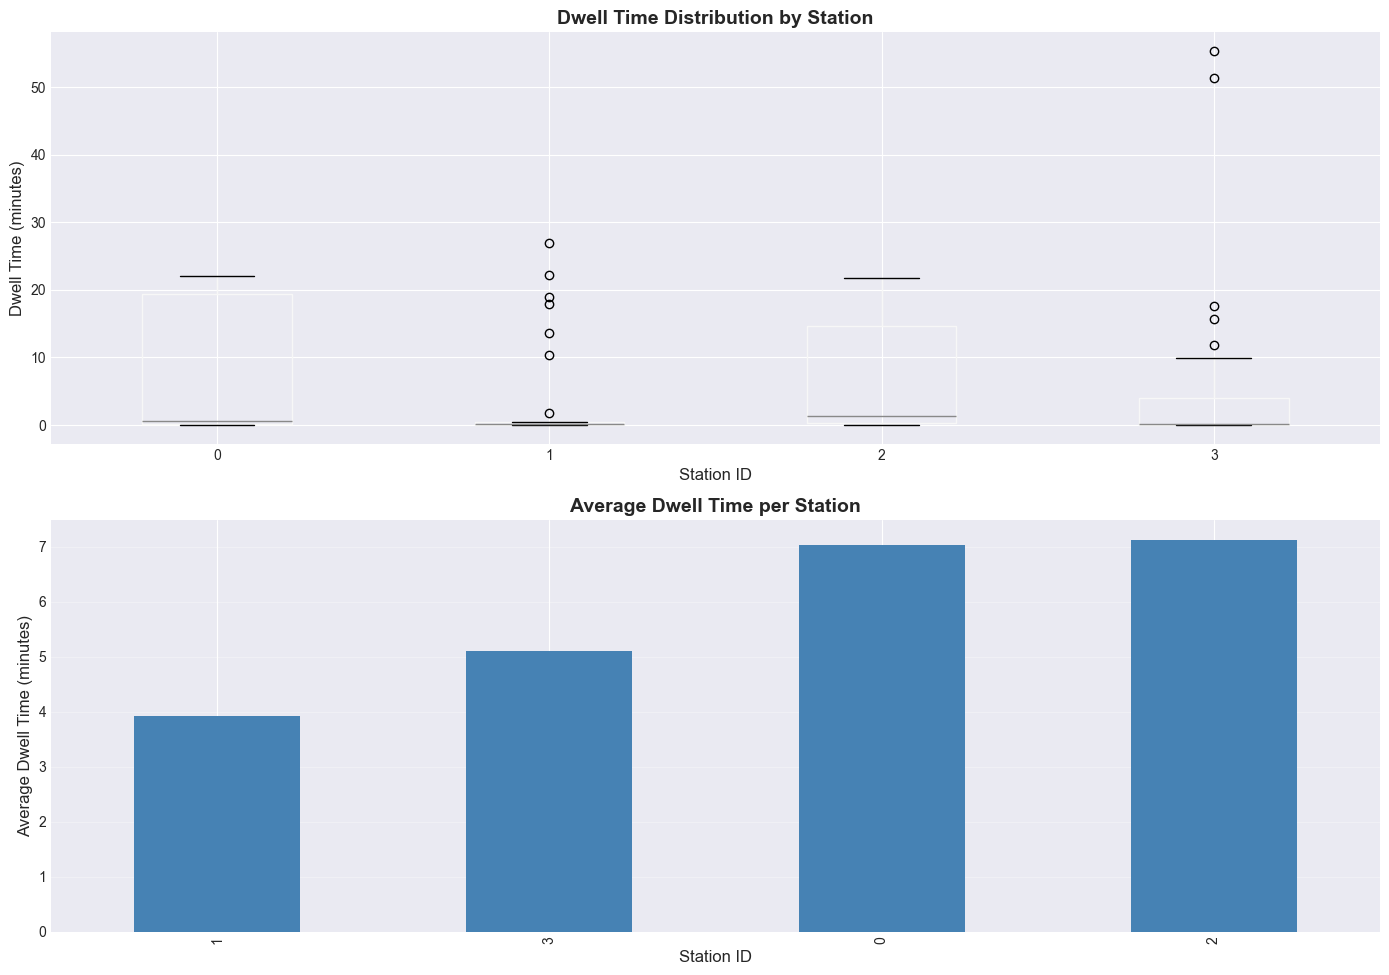

In [13]:
# Analyze dwell time at each station
dwell_stats = visits_df.groupby('station').agg({
    'duration_minutes': ['mean', 'median', 'std', 'min', 'max', 'count']
}).round(2)

dwell_stats.columns = ['Mean (min)', 'Median (min)', 'Std Dev', 'Min (min)', 'Max (min)', 'Visit Count']

print("Dwell Time Statistics by Station:")
print(dwell_stats)

# Visualize dwell time distribution
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Box plot
visits_df.boxplot(column='duration_minutes', by='station', ax=axes[0])
axes[0].set_title('Dwell Time Distribution by Station', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Station ID', fontsize=12)
axes[0].set_ylabel('Dwell Time (minutes)', fontsize=12)
axes[0].get_figure().suptitle('')  # Remove default title

# Bar plot of mean dwell time
mean_dwell = visits_df.groupby('station')['duration_minutes'].mean().sort_values()
mean_dwell.plot(kind='bar', ax=axes[1], color='steelblue')
axes[1].set_title('Average Dwell Time per Station', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Station ID', fontsize=12)
axes[1].set_ylabel('Average Dwell Time (minutes)', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 2.3 Calculate Travel Time Between Stations

In [14]:
# Calculate travel time between consecutive stations
travel_times = []

for group, group_visits in visits_df.groupby('group'):
    group_visits = group_visits.sort_values('start_time')
    
    for i in range(len(group_visits) - 1):
        current_visit = group_visits.iloc[i]
        next_visit = group_visits.iloc[i + 1]
        
        travel_time_seconds = (next_visit['start_time'] - current_visit['end_time']).total_seconds()
        
        travel_times.append({
            'group': group,
            'from_station': current_visit['station'],
            'to_station': next_visit['station'],
            'travel_time_seconds': travel_time_seconds,
            'travel_time_minutes': travel_time_seconds / 60,
            'departure_time': current_visit['end_time'],
            'arrival_time': next_visit['start_time']
        })

travel_df = pd.DataFrame(travel_times)

print(f"Total station transitions: {len(travel_df)}")
print(f"\nTravel Time Summary:")
print(travel_df['travel_time_minutes'].describe())

travel_df.head(10)

Total station transitions: 96

Travel Time Summary:
count    96.000000
mean      2.551958
std       8.964546
min       0.008335
25%       0.016665
50%       0.016693
75%       0.083324
max      47.262644
Name: travel_time_minutes, dtype: float64


,group,from_station,to_station,travel_time_seconds,travel_time_minutes,departure_time,arrival_time
0,Group 1,3,1,7.007112,0.116785,2025-08-01 12:59:35.006176,2025-08-01 12:59:42.013288
1,Group 1,1,3,0.999930,0.016665,2025-08-01 12:59:43.006495,2025-08-01 12:59:44.006425
2,Group 1,3,1,10.000696,0.166678,2025-08-01 12:59:45.006623,2025-08-01 12:59:55.007319
3,Group 1,1,3,1.002810,0.016713,2025-08-01 12:59:55.007319,2025-08-01 12:59:56.010129
4,Group 1,3,1,0.999985,0.016666,2025-08-01 13:02:52.006407,2025-08-01 13:02:53.006392
5,Group 1,1,3,1.000371,0.016673,2025-08-01 13:02:53.006392,2025-08-01 13:02:54.006763
6,Group 1,3,1,3.000692,0.050012,2025-08-01 13:02:57.006251,2025-08-01 13:03:00.006943
7,Group 1,1,3,2.999139,0.049986,2025-08-01 13:03:00.006943,2025-08-01 13:03:03.006082
8,Group 1,3,1,1.000482,0.016675,2025-08-01 13:10:24.006002,2025-08-01 13:10:25.006484
9,Group 1,1,3,1.000608,0.016677,2025-08-01 13:10:25.006484,2025-08-01 13:10:26.007092


Average Travel Time Matrix (minutes):
to_station       0     1     2      3
from_station                         
0             0.00  0.00  0.21   6.89
1             0.00  0.00  0.03   3.76
2             0.04  0.00  0.00  20.91
3             0.02  1.24  0.02   0.00


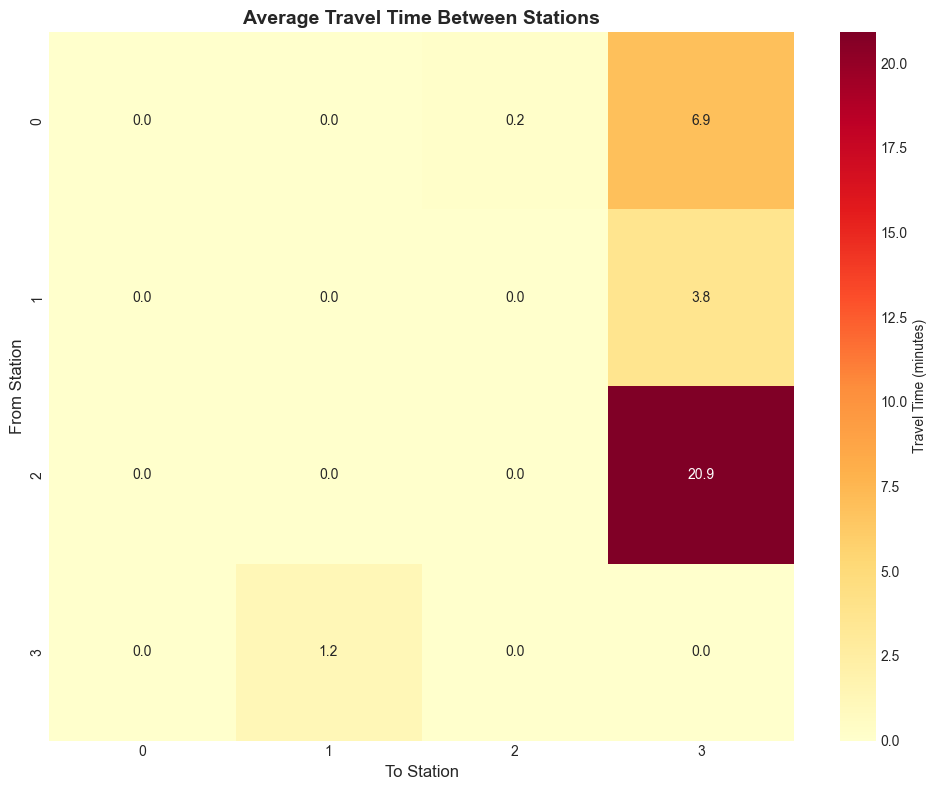

In [15]:
# Create transition matrix (average travel time between stations)
transition_matrix = travel_df.groupby(['from_station', 'to_station'])['travel_time_minutes'].mean().unstack(fill_value=0)

print("Average Travel Time Matrix (minutes):")
print(transition_matrix.round(2))

# Visualize transition matrix
plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Travel Time (minutes)'})
plt.title('Average Travel Time Between Stations', fontsize=14, fontweight='bold')
plt.xlabel('To Station', fontsize=12)
plt.ylabel('From Station', fontsize=12)
plt.tight_layout()
plt.show()

Most Common Station Transitions:
from_station  to_station
3             1             29
1             3             22
0             3             12
2             0              9
3             0              8
1             2              7
0             2              6
2             3              2
3             2              1
dtype: int64


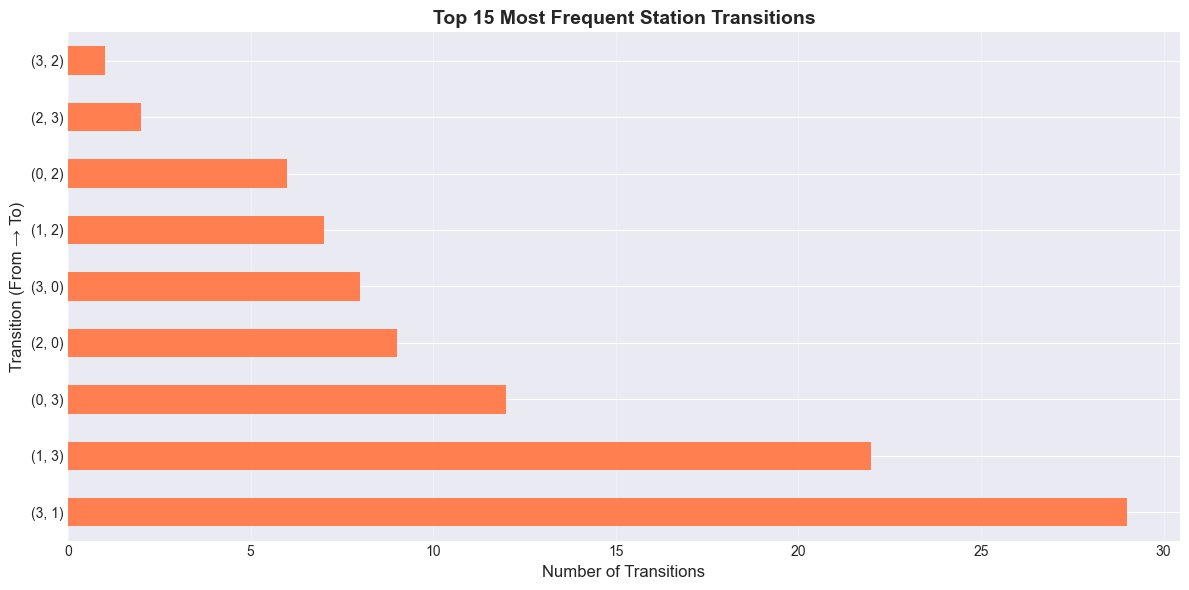

In [16]:
# Analyze most common transitions
transition_counts = travel_df.groupby(['from_station', 'to_station']).size().sort_values(ascending=False)

print("Most Common Station Transitions:")
print(transition_counts.head(10))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
transition_counts.head(15).plot(kind='barh', ax=ax, color='coral')
ax.set_title('Top 15 Most Frequent Station Transitions', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Transitions', fontsize=12)
ax.set_ylabel('Transition (From → To)', fontsize=12)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

---
# Phase 3: Predictive Modeling

Build models to predict:
1. **Next Station Arrival Time**: When will a group reach the next station?
2. **Total Completion Time**: How long until a group finishes all stations?

## 3.1 Feature Engineering for Prediction

In [17]:
# Create features for predicting next station arrival
prediction_data = []

for group, group_visits in visits_df.groupby('group'):
    group_visits = group_visits.sort_values('start_time').reset_index(drop=True)
    
    for i in range(len(group_visits) - 1):
        current = group_visits.iloc[i]
        next_visit = group_visits.iloc[i + 1]
        
        # Calculate time to next station
        time_to_next = (next_visit['start_time'] - current['end_time']).total_seconds() / 60
        
        # Get centroid coordinates
        current_centroid = station_info[station_info['station'] == current['station']].iloc[0]
        next_centroid = station_info[station_info['station'] == next_visit['station']].iloc[0]
        
        # Calculate Euclidean distance
        distance = np.sqrt(
            (next_centroid['centroid_x'] - current_centroid['centroid_x'])**2 + 
            (next_centroid['centroid_y'] - current_centroid['centroid_y'])**2
        )
        
        prediction_data.append({
            'group': group,
            'current_station': current['station'],
            'next_station': next_visit['station'],
            'visit_number': i,  # Which visit in sequence
            'current_dwell_time': current['duration_minutes'],
            'distance_to_next': distance,
            'time_of_day_hour': current['end_time'].hour + current['end_time'].minute / 60,
            'elapsed_time_minutes': (current['end_time'] - group_visits.iloc[0]['start_time']).total_seconds() / 60,
            'avg_prev_dwell': group_visits.iloc[:i+1]['duration_minutes'].mean() if i > 0 else current['duration_minutes'],
            'target_time_to_next': time_to_next  # Target variable
        })

pred_df = pd.DataFrame(prediction_data)

print(f"Prediction dataset size: {len(pred_df)}")
print(f"\nFeatures: {[col for col in pred_df.columns if col != 'target_time_to_next']}")
print(f"\nTarget variable: target_time_to_next (minutes to reach next station)")

pred_df.head(10)

Prediction dataset size: 96

Features: ['group', 'current_station', 'next_station', 'visit_number', 'current_dwell_time', 'distance_to_next', 'time_of_day_hour', 'elapsed_time_minutes', 'avg_prev_dwell']

Target variable: target_time_to_next (minutes to reach next station)


,group,current_station,next_station,visit_number,current_dwell_time,distance_to_next,time_of_day_hour,elapsed_time_minutes,avg_prev_dwell,target_time_to_next
0,Group 1,3,1,0,0.066632,5.650224,12.983333,0.066632,0.066632,0.116785
1,Group 1,1,3,1,0.016553,5.650224,12.983333,0.199970,0.041593,0.016665
2,Group 1,3,1,2,0.016670,5.650224,12.983333,0.233306,0.033285,0.166678
3,Group 1,1,3,3,0.000000,5.650224,12.983333,0.399984,0.024964,0.016713
4,Group 1,3,1,4,2.933271,5.650224,13.033333,3.349969,0.606625,0.016666
5,Group 1,1,3,5,0.000000,5.650224,13.033333,3.366635,0.505521,0.016673
6,Group 1,3,1,6,0.049991,5.650224,13.033333,3.433299,0.440445,0.050012
7,Group 1,1,3,7,0.000000,5.650224,13.050000,3.483311,0.385390,0.049986
8,Group 1,3,1,8,7.349999,5.650224,13.166667,10.883295,1.159235,0.016675
9,Group 1,1,3,9,0.000000,5.650224,13.166667,10.899970,1.043312,0.016677


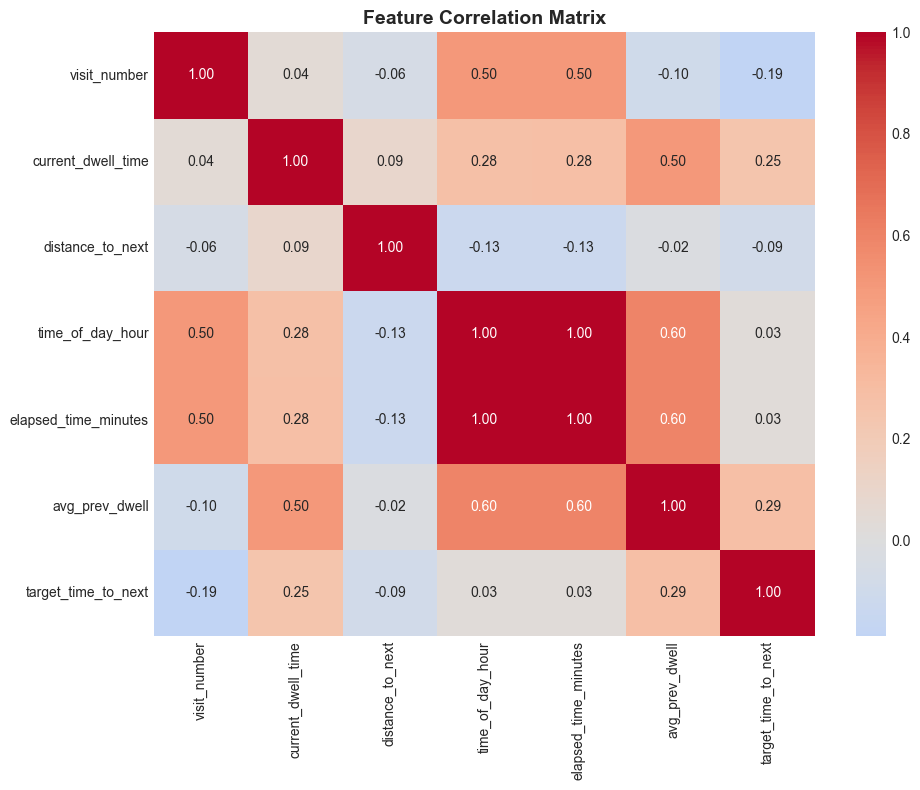

In [18]:
# Check correlations
numeric_cols = ['visit_number', 'current_dwell_time', 'distance_to_next', 
                'time_of_day_hour', 'elapsed_time_minutes', 'avg_prev_dwell', 'target_time_to_next']

plt.figure(figsize=(10, 8))
sns.heatmap(pred_df[numeric_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3.2 Model 1: Predict Time to Next Station

In [19]:
# Prepare training data
feature_cols = ['current_station', 'next_station', 'visit_number', 'current_dwell_time', 
                'distance_to_next', 'time_of_day_hour', 'elapsed_time_minutes', 'avg_prev_dwell']

X = pred_df[feature_cols]
y = pred_df['target_time_to_next']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 76
Test samples: 20


In [20]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

# Evaluate
print("Random Forest - Time to Next Station Prediction")
print("=" * 50)
print(f"Training Set:")
print(f"  MAE: {mean_absolute_error(y_train, y_pred_train):.2f} minutes")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f} minutes")
print(f"  R²: {r2_score(y_train, y_pred_train):.3f}")

print(f"\nTest Set:")
print(f"  MAE: {mean_absolute_error(y_test, y_pred_test):.2f} minutes")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f} minutes")
print(f"  R²: {r2_score(y_test, y_pred_test):.3f}")

Random Forest - Time to Next Station Prediction
Training Set:
  MAE: 2.04 minutes
  RMSE: 4.22 minutes
  R²: 0.820

Test Set:
  MAE: 2.38 minutes
  RMSE: 4.67 minutes
  R²: -20.198


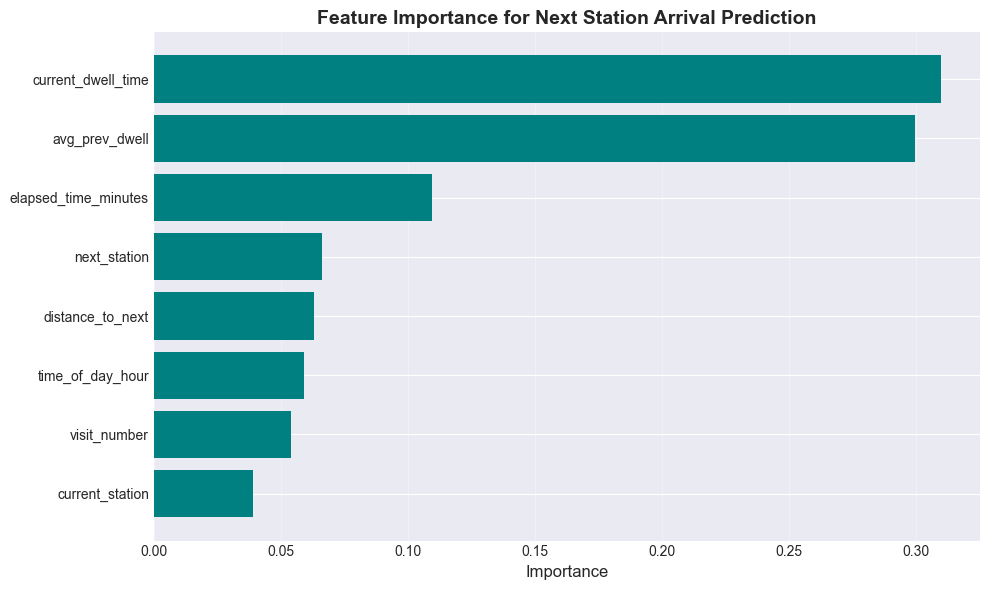


Top Features:
                feature  importance
3    current_dwell_time    0.309738
7        avg_prev_dwell    0.299619
6  elapsed_time_minutes    0.109511
1          next_station    0.066071
4      distance_to_next    0.062965
5      time_of_day_hour    0.059070
2          visit_number    0.054105
0       current_station    0.038921


In [21]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='teal')
plt.xlabel('Importance', fontsize=12)
plt.title('Feature Importance for Next Station Arrival Prediction', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTop Features:")
print(feature_importance)

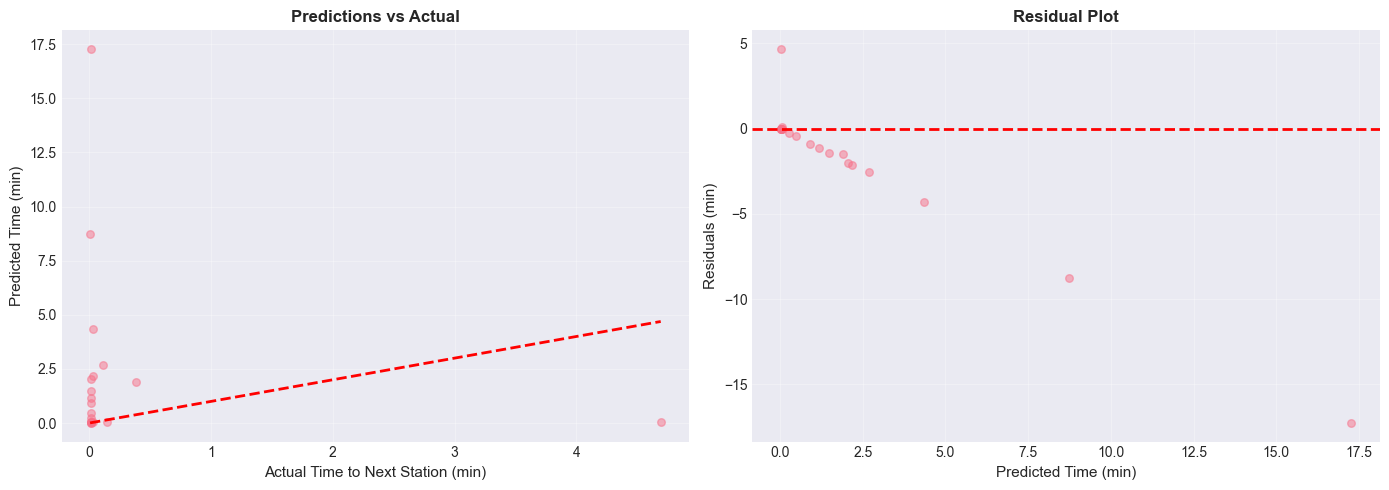

In [22]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, y_pred_test, alpha=0.5, s=30)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Time to Next Station (min)', fontsize=11)
axes[0].set_ylabel('Predicted Time (min)', fontsize=11)
axes[0].set_title('Predictions vs Actual', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = y_test - y_pred_test
axes[1].scatter(y_pred_test, residuals, alpha=0.5, s=30)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Time (min)', fontsize=11)
axes[1].set_ylabel('Residuals (min)', fontsize=11)
axes[1].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3.3 Model 2: Predict Total Completion Time

In [23]:
# Calculate total time for each group to complete all stations
completion_data = []

for group, group_visits in visits_df.groupby('group'):
    group_visits = group_visits.sort_values('start_time')
    
    if len(group_visits) < 2:
        continue
    
    start_time = group_visits.iloc[0]['start_time']
    end_time = group_visits.iloc[-1]['end_time']
    total_time = (end_time - start_time).total_seconds() / 60
    
    completion_data.append({
        'group': group,
        'total_stations_visited': len(group_visits),
        'unique_stations': group_visits['station'].nunique(),
        'avg_dwell_time': group_visits['duration_minutes'].mean(),
        'total_dwell_time': group_visits['duration_minutes'].sum(),
        'first_station': group_visits.iloc[0]['station'],
        'start_hour': start_time.hour + start_time.minute / 60,
        'total_completion_time': total_time  # Target
    })

completion_df = pd.DataFrame(completion_data)

print(f"Groups analyzed: {len(completion_df)}")
print(f"\nCompletion Time Statistics:")
print(completion_df['total_completion_time'].describe())

completion_df.head()

Groups analyzed: 6

Completion Time Statistics:
count      6.000000
mean     132.760108
std       30.020980
min       80.856732
25%      122.177025
50%      141.323692
75%      155.890703
max      156.515354
Name: total_completion_time, dtype: float64


,group,total_stations_visited,unique_stations,avg_dwell_time,total_dwell_time,first_station,start_hour,total_completion_time
0,Group 1,25,4,3.140924,78.523111,3,12.983333,80.856732
1,Group 2,9,4,9.684246,87.158211,3,12.983333,120.604936
2,Group 3,11,4,9.832530,108.157829,3,12.983333,155.936240
3,Group 5,27,4,2.965596,80.071104,3,12.983333,126.893293
4,Group 6,20,4,6.498424,129.968473,0,12.983333,156.515354


In [24]:
# Prepare data for completion time prediction
completion_features = ['total_stations_visited', 'unique_stations', 'avg_dwell_time', 
                       'first_station', 'start_hour']

X_comp = completion_df[completion_features]
y_comp = completion_df['total_completion_time']

# Split
X_train_comp, X_test_comp, y_train_comp, y_test_comp = train_test_split(
    X_comp, y_comp, test_size=0.2, random_state=42
)

# Train Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb_model.fit(X_train_comp, y_train_comp)

# Predictions
y_pred_train_comp = gb_model.predict(X_train_comp)
y_pred_test_comp = gb_model.predict(X_test_comp)

# Evaluate
print("Gradient Boosting - Total Completion Time Prediction")
print("=" * 50)
print(f"Training Set:")
print(f"  MAE: {mean_absolute_error(y_train_comp, y_pred_train_comp):.2f} minutes")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train_comp, y_pred_train_comp)):.2f} minutes")
print(f"  R²: {r2_score(y_train_comp, y_pred_train_comp):.3f}")

print(f"\nTest Set:")
print(f"  MAE: {mean_absolute_error(y_test_comp, y_pred_test_comp):.2f} minutes")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_comp, y_pred_test_comp)):.2f} minutes")
print(f"  R²: {r2_score(y_test_comp, y_pred_test_comp):.3f}")

Gradient Boosting - Total Completion Time Prediction
Training Set:
  MAE: 0.00 minutes
  RMSE: 0.00 minutes
  R²: 1.000

Test Set:
  MAE: 40.67 minutes
  RMSE: 41.02 minutes
  R²: -3.261


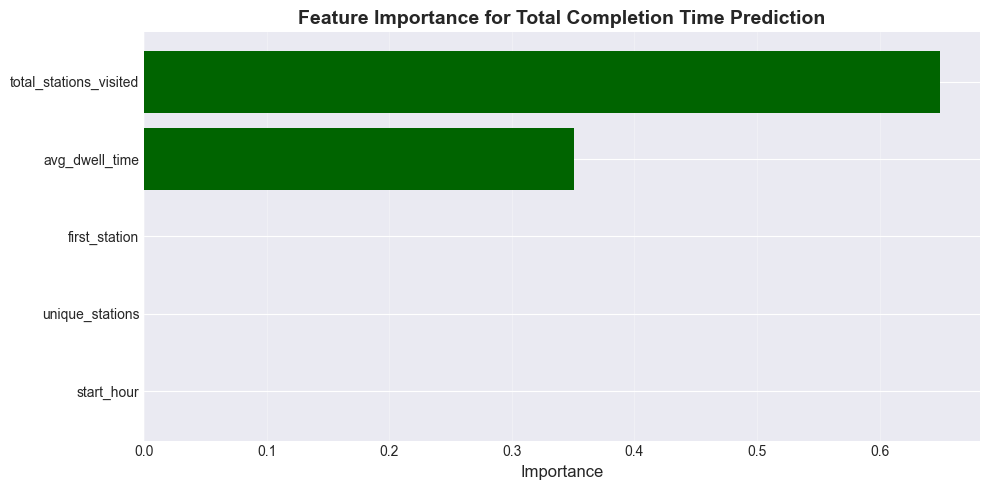


Top Features:
                  feature  importance
0  total_stations_visited    0.649363
2          avg_dwell_time    0.350625
3           first_station    0.000011
1         unique_stations    0.000000
4              start_hour    0.000000


In [25]:
# Feature importance for completion time
comp_importance = pd.DataFrame({
    'feature': completion_features,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(comp_importance['feature'], comp_importance['importance'], color='darkgreen')
plt.xlabel('Importance', fontsize=12)
plt.title('Feature Importance for Total Completion Time Prediction', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTop Features:")
print(comp_importance)

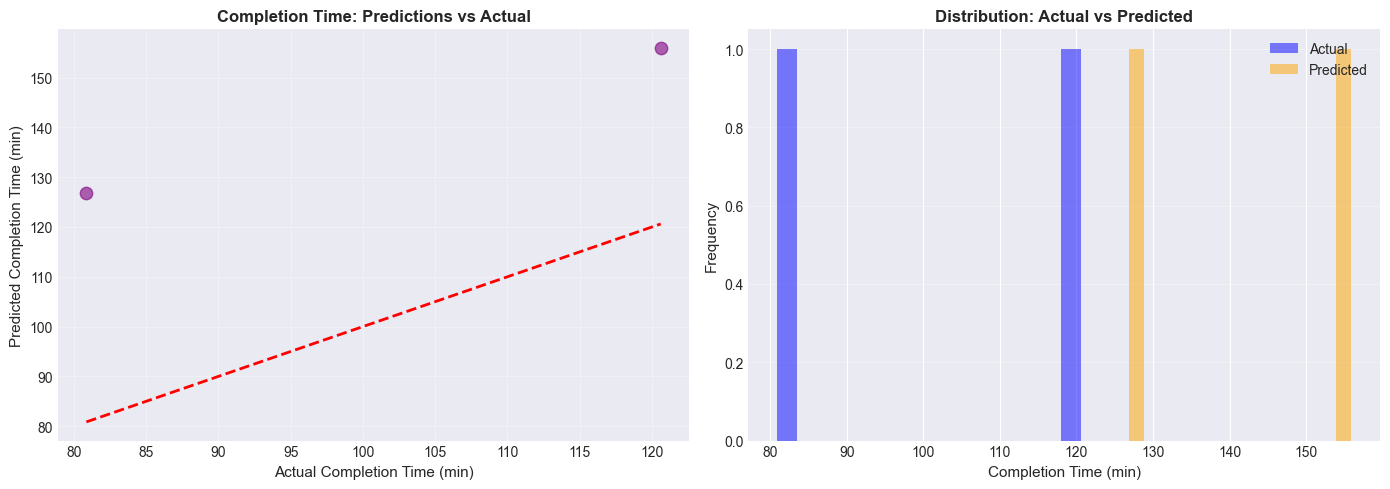

In [26]:
# Visualize completion time predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test_comp, y_pred_test_comp, alpha=0.6, s=80, color='purple')
axes[0].plot([y_test_comp.min(), y_test_comp.max()], 
             [y_test_comp.min(), y_test_comp.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Completion Time (min)', fontsize=11)
axes[0].set_ylabel('Predicted Completion Time (min)', fontsize=11)
axes[0].set_title('Completion Time: Predictions vs Actual', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Distribution comparison
axes[1].hist(y_test_comp, bins=15, alpha=0.5, label='Actual', color='blue')
axes[1].hist(y_pred_test_comp, bins=15, alpha=0.5, label='Predicted', color='orange')
axes[1].set_xlabel('Completion Time (min)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Distribution: Actual vs Predicted', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---
# Summary and Insights

In [27]:
print("=" * 70)
print(f"RTLS ANALYSIS SUMMARY - {WORKSHOP}")
print("=" * 70)

print("\n📍 PHASE 1: Station Detection (Clustering)")
print(f"  • Number of stations detected: {optimal_k}")
print(f"  • Method: K-Means clustering")
print(f"  • Silhouette score: {max(silhouette_scores):.3f}")

print("\n⏱️  PHASE 2: Temporal Analysis")
print(f"  • Total station visits: {len(visits_df)}")
print(f"  • Average dwell time: {visits_df['duration_minutes'].mean():.1f} minutes")
print(f"  • Average travel time: {travel_df['travel_time_minutes'].mean():.1f} minutes")
print(f"  • Most visited station: {visits_df['station'].mode().values[0]}")

print("\n🔮 PHASE 3: Predictive Modeling")
print(f"\n  Model 1: Time to Next Station")
print(f"    • Test MAE: {mean_absolute_error(y_test, y_pred_test):.2f} minutes")
print(f"    • Test R²: {r2_score(y_test, y_pred_test):.3f}")
print(f"    • Top feature: {feature_importance.iloc[0]['feature']}")

print(f"\n  Model 2: Total Completion Time")
print(f"    • Test MAE: {mean_absolute_error(y_test_comp, y_pred_test_comp):.2f} minutes")
print(f"    • Test R²: {r2_score(y_test_comp, y_pred_test_comp):.3f}")
print(f"    • Top feature: {comp_importance.iloc[0]['feature']}")

print("\n" + "=" * 70)
print("💡 Next Steps:")
print("  1. Fine-tune clustering parameters based on domain knowledge")
print("  2. Add more features (group size, equipment, workshop conditions)")
print("  3. Try advanced models (XGBoost, Neural Networks)")
print("  4. Implement real-time prediction system")
print("  5. Compare results across different workshops")
print("=" * 70)

RTLS ANALYSIS SUMMARY - Workshop2

📍 PHASE 1: Station Detection (Clustering)
  • Number of stations detected: 4
  • Method: K-Means clustering
  • Silhouette score: 0.691

⏱️  PHASE 2: Temporal Analysis
  • Total station visits: 102
  • Average dwell time: 5.4 minutes
  • Average travel time: 2.6 minutes
  • Most visited station: 3

🔮 PHASE 3: Predictive Modeling

  Model 1: Time to Next Station
    • Test MAE: 2.38 minutes
    • Test R²: -20.198
    • Top feature: current_dwell_time

  Model 2: Total Completion Time
    • Test MAE: 40.67 minutes
    • Test R²: -3.261
    • Top feature: total_stations_visited

💡 Next Steps:
  1. Fine-tune clustering parameters based on domain knowledge
  2. Add more features (group size, equipment, workshop conditions)
  3. Try advanced models (XGBoost, Neural Networks)
  4. Implement real-time prediction system
  5. Compare results across different workshops


## Save Results

In [28]:
# Save processed data and models
import pickle
from pathlib import Path

# Create output directory for this workshop
output_dir = Path(f'../data/results/{WORKSHOP}')
output_dir.mkdir(parents=True, exist_ok=True)

# Save station assignments
df[['name', 'x', 'y', 'z', 'time', 'station']].to_csv(
    output_dir / 'data_with_stations.csv', index=False
)

# Save station info
station_info.to_csv(output_dir / 'station_centroids.csv', index=False)

# Save visits data
visits_df.to_csv(output_dir / 'station_visits.csv', index=False)

# Save travel times
travel_df.to_csv(output_dir / 'travel_times.csv', index=False)

# Save prediction data
pred_df.to_csv(output_dir / 'prediction_features.csv', index=False)
completion_df.to_csv(output_dir / 'completion_data.csv', index=False)

# Save models
with open(output_dir / 'rf_next_station_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open(output_dir / 'gb_completion_model.pkl', 'wb') as f:
    pickle.dump(gb_model, f)

with open(output_dir / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f"✅ All results saved to {output_dir}/")
print(f"\nSaved files:")
print(f"  • data_with_stations.csv")
print(f"  • station_centroids.csv")
print(f"  • station_visits.csv")
print(f"  • travel_times.csv")
print(f"  • prediction_features.csv")
print(f"  • completion_data.csv")
print(f"  • rf_next_station_model.pkl")
print(f"  • gb_completion_model.pkl")
print(f"  • scaler.pkl")

✅ All results saved to ../data/results/Workshop2/

Saved files:
  • data_with_stations.csv
  • station_centroids.csv
  • station_visits.csv
  • travel_times.csv
  • prediction_features.csv
  • completion_data.csv
  • rf_next_station_model.pkl
  • gb_completion_model.pkl
  • scaler.pkl
